# Week 10 Homework

>Parks and green spaces provide a variety of health benefits by promoting physical activity, connection to nature and opportunities for community engagement. Nature-based programs can even be prescribed by health care providers as part of alternative, cost-effective treatment plans.

>In a paper recently published in the North Carolina Medical Journal, Lincoln Larson and Aaron Hipp, associate professors of parks, recreation and tourism management at NC State, provide an overview of how parks and green spaces can help alleviate contemporary health challenges.

[Source](https://cnr.ncsu.edu/news/2022/04/parks-green-spaces-improve-health/)

## 10.1 Finding the nearest parks to schools in Los Angeles County
You are given information on the point locations of schools in the LA Unified Schoo School District (LAUSD) (``` data/Schools_LAUSD.geojson```) and polygons of LA city parks (```data/Recreation_and_Parks.geojson ```)

1. Load the school and park data. For calcuating distances, what should you check and potentially change? 
2. Find the nearest park to each school in the LAUSD. Capture the  ``` Name ``` of the closest park. Note, this is not as straight forward as just copying and pasting from section-02 week 10! You actually have to think logically what columns are needed (centroids or geometries? what is the target dataframe?). Think carefully! 
3. Create an interactive map which plots the LAUSD schools locations and has a ``` Tooltip ``` capability of showing the ``` FULLNAME ``` of the school (using alias of ``` School Name ```) and the name of the closest park using the alias of ``` Nearest Park Name ```.
4. Save your map as a .html file, upload to your GitHub, and provide a link where anyone can see the final product. Paste this link into the notebook you submit for the assignment. 

In [21]:
# Import necessary modules
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
import folium

In [22]:
# Read the data
park= gpd.read_file('data/Recreation_and_Parks.geojson')

school = gpd.read_file('data/Schools_LAUSD.geojson')

In [23]:
park.head()

OBJECTID  Area_Acres Park_ID CD_Real  \
0         1    8.433364     512      03   
1         2    1.387374     883      15   
2         3    3.173861     320      15   
3         4    0.154871     366      08   
4         5    0.960725     213      09   

                                             Address Region  \
0                                   23751 Ingomar St      V   
1  Adjacent to Angels Gate Park at 3400 Gaffey St...      P   
2                                1464 E 109th Street      P   
3                                    4726 8th Avenue      P   
4                                  4800 S. Hoover St      P   

                             Name Park_Class CD_NEW  \
0               Lazy J Ranch Park          N     12   
1              Lookout Point Park          N     15   
2  109th Street Recreation Center          N     15   
3               Angeles Mesa Park          N      8   
4            Julian C. Dixon Park          N      9   

                                             TOOLTIP       ACRES  \
0  Name: Lazy J Ranch Park\nLocation: 23751 Ingom...   8.4333635   
1  Name: Lookout Point Park\nLocation: Adjacent t...  1.38737377   
2  Name: 109th Street Recreation Center\nLocation...  3.17386107   
3  Name: Angeles Mesa Park\nLocation: 4726 8th Av...   0.1548711   
4  Name: Julian C. Dixon Park\nLocation: 4800 S. ...  0.96072542   

                                            geometry  
0  POLYGON ((-118.64451 34.21238, -118.64451 34.2...  
1  POLYGON ((-118.29192 33.71197, -118.29192 33.7...  
2  POLYGON ((-118.24925 33.93590, -118.24917 33.9...  
3  POLYGON ((-118.32523 34.00014, -118.32523 34.0...  
4  POLYGON ((-118.28680 33.99881, -118.28664 33.9...

In [24]:
school.head()

ID  LOCN               MPD_NAME              ADDRESS             CITY  \
0   1  2835  VISTA DEL VALLE AC DL  12411 N BROMONT AVE      LOS ANGELES   
1   2  2820  PARMELEE AVE EL DL SP       1338 E 76TH PL      LOS ANGELES   
2   3  2773        OCHOA LC DLC SP     5057 LIVE OAK ST           CUDAHY   
3   4  2840    WILTON PL EL DLC KO      745 S WILTON PL      LOS ANGELES   
4   5  2814    MILES AVE EL DLC SP       6020 MILES AVE  HUNTINGTON PARK   

     ZIP MPD_TYPE MAP_TYPE                  LABEL  \
0  91340       DS       ED  Vista del Valle Ac DL   
1  90001       DS       ED  Parmelee Ave El DL Sp   
2  90201       DS       ED        Ochoa LC DLC Sp   
3  90005       DK       ED    Wilton Pl El DLC Ko   
4  90255       DS       ED    Miles Ave El DLC Sp   

                        MAP_DESC               MPD_DESC  LD  \
0  Spanish Dual Language Program  Dual Language Program   0   
1  Spanish Dual Language Program  Dual Language Program   0   
2  Spanish Dual Language Program  Dual Language Program   0   
3   Korean Dual Language Program  Dual Language Program   0   
4  Spanish Dual Language Program  Dual Language Program   0   

                                            FULLNAME CDSCODE CHARTER  \
0  Vista del Valle Dual Language Academy Dual Lan...                   
1   Parmelee Avenue Elementary Dual Language Spanish                   
2  Ellen Ochoa Learning Center Dual Language Spanish                   
3       Wilton Place Elementary Dual Language Korean                   
4      Miles Avenue Elementary Dual Language Spanish                   

  MAP_TYPE_MAPPING                                            TOOLTIP  \
0               ES  Name: Vista del Valle Dual Language Academy Du...   
1               ES  Name: Parmelee Avenue Elementary Dual Language...   
2               ES  Name: Ellen Ochoa Learning Center Dual Languag...   
3               ES  Name: Wilton Place Elementary Dual Language Ko...   
4               ES  Name: Miles Avenue Elementary Dual Language Sp...   

                                           NLA_URL  \
0  navigatela/reports/lausd_school_report.cfm?PK=1   
1  navigatela/reports/lausd_school_report.cfm?PK=2   
2  navigatela/reports/lausd_school_report.cfm?PK=3   
3  navigatela/reports/lausd_school_report.cfm?PK=4   
4  navigatela/reports/lausd_school_report.cfm?PK=5   

                      geometry  
0  POINT (-118.42169 34.29553)  
1  POINT (-118.25099 33.97006)  
2  POINT (-118.17660 33.96793)  
3  POINT (-118.31537 34.05853)  
4  POINT (-118.21780 33.97755)

## Check crs

In [25]:
print(f'The crs of park is: {park.crs}')
print(f'The crs of school is: {school.crs}')

The crs of park is: epsg:4326
The crs of school is: epsg:4326


In [26]:
park = park.to_crs(epsg=3067)
school = school.to_crs(epsg=3067)

In [27]:
def get_nearest_values(row, other_gdf, point_column, value_column="geometry"):
    """Find the nearest point and return the corresponding value from specified value column."""
    
    # Create an union of the other GeoDataFrame's geometries:
    other_points = other_gdf["centroid"].unary_union
    
    # Find the nearest points
    nearest_geoms = nearest_points(row[point_column], other_points)
    
    # Get corresponding values from the other df
    nearest_data = other_gdf.loc[other_gdf["centroid"] == nearest_geoms[1]]
    
    nearest_value = nearest_data[value_column].values[0]
    
    return nearest_value

In [28]:
park['centroid'] = park.centroid
park.head()

OBJECTID  Area_Acres Park_ID CD_Real  \
0         1    8.433364     512      03   
1         2    1.387374     883      15   
2         3    3.173861     320      15   
3         4    0.154871     366      08   
4         5    0.960725     213      09   

                                             Address Region  \
0                                   23751 Ingomar St      V   
1  Adjacent to Angels Gate Park at 3400 Gaffey St...      P   
2                                1464 E 109th Street      P   
3                                    4726 8th Avenue      P   
4                                  4800 S. Hoover St      P   

                             Name Park_Class CD_NEW  \
0               Lazy J Ranch Park          N     12   
1              Lookout Point Park          N     15   
2  109th Street Recreation Center          N     15   
3               Angeles Mesa Park          N      8   
4            Julian C. Dixon Park          N      9   

                                             TOOLTIP       ACRES  \
0  Name: Lazy J Ranch Park\nLocation: 23751 Ingom...   8.4333635   
1  Name: Lookout Point Park\nLocation: Adjacent t...  1.38737377   
2  Name: 109th Street Recreation Center\nLocation...  3.17386107   
3  Name: Angeles Mesa Park\nLocation: 4726 8th Av...   0.1548711   
4  Name: Julian C. Dixon Park\nLocation: 4800 S. ...  0.96072542   

                                            geometry  \
0  POLYGON ((-2728718.751 15623568.405, -2728717....   
1  POLYGON ((-2785774.485 15669003.142, -2785771....   
2  POLYGON ((-2779794.504 15641083.407, -2779802....   
3  POLYGON ((-2769444.289 15636423.338, -2769438....   
4  POLYGON ((-2773258.861 15635123.968, -2773274....   

                            centroid  
0  POINT (-2728622.720 15623506.109)  
1  POINT (-2785729.994 15668953.079)  
2  POINT (-2779840.029 15641008.287)  
3  POINT (-2769419.491 15636423.769)  
4  POINT (-2773249.093 15635077.300)

In [29]:
school["nearest park"] = school.apply(get_nearest_values, other_gdf=park, point_column="geometry", value_column="Name", axis=1)

In [30]:
school

ID  LOCN                  MPD_NAME              ADDRESS  \
0        1  2835     VISTA DEL VALLE AC DL  12411 N BROMONT AVE   
1        2  2820     PARMELEE AVE EL DL SP       1338 E 76TH PL   
2        3  2773           OCHOA LC DLC SP     5057 LIVE OAK ST   
3        4  2840       WILTON PL EL DLC KO      745 S WILTON PL   
4        5  2814       MILES AVE EL DLC SP       6020 MILES AVE   
...    ...   ...                       ...                  ...   
1208  1209  6493  SAN PASCUAL ES STEAM MAG  815 SAN PASCUAL AVE   
1209  1210  8490       WILMINGTON MS STEAM        1700 GULF AVE   
1210  1211  7604         MILLIKAN STEM MAG  5041 SUNNYSLOPE AVE   
1211  1212  6087                      GALA       1067 WEST BLVD   
1212  1213  8433    EAST VALLEY SKILLS CTR      8601 ARLETA AVE   

                 CITY    ZIP MPD_TYPE MAP_TYPE                       LABEL  \
0         LOS ANGELES  91340       DS       ED       Vista del Valle Ac DL   
1         LOS ANGELES  90001       DS       ED       Parmelee Ave El DL Sp   
2              CUDAHY  90201       DS       ED             Ochoa LC DLC Sp   
3         LOS ANGELES  90005       DK       ED         Wilton Pl El DLC Ko   
4     HUNTINGTON PARK  90255       DS       ED         Miles Ave El DLC Sp   
...               ...    ...      ...      ...                         ...   
1208      LOS ANGELES  90042       ES        M   San Pascual Ave STEAM Mag   
1209       WILMINGTON  90744        J        M     Wilmington Middle STEAM   
1210     SHERMAN OAKS  91423        J        M           Millikan STEM Mag   
1211      LOS ANGELES  90019       EJ       SS  Girls Academic Ldrshp Acad   
1212       SUN VALLEY  91352        A        O      East Valley Skills Ctr   

                                               MAP_DESC  \
0                         Spanish Dual Language Program   
1                         Spanish Dual Language Program   
2                         Spanish Dual Language Program   
3                          Korean Dual Language Program   
4                         Spanish Dual Language Program   
...                                                 ...   
1208                                      Magnet School   
1209                                      Magnet School   
1210                                      Magnet School   
1211       Span School (Span School, Special Ed School)   
1212  Adult Education, Skill Center, Occupational Ce...   

                                       MPD_DESC  LD  \
0                         Dual Language Program   0   
1                         Dual Language Program   0   
2                         Dual Language Program   0   
3                         Dual Language Program   0   
4                         Dual Language Program   0   
...                                         ...  ..   
1208  Elementary School Magnet - Self Contained   0   
1209      Middle School Magnet - Self Contained   0   
1210      Middle School Magnet - Self Contained   0   
1211                                Span School   0   
1212                     Community Adult School   0   

                                               FULLNAME         CDSCODE  \
0     Vista del Valle Dual Language Academy Dual Lan...                   
1      Parmelee Avenue Elementary Dual Language Spanish                   
2     Ellen Ochoa Learning Center Dual Language Spanish                   
3          Wilton Place Elementary Dual Language Korean                   
4         Miles Avenue Elementary Dual Language Spanish                   
...                                                 ...             ...   
1208  San Pascual Avenue Elementary Science, Technol...  19647336019046   
1209  Wilmington Middle School Science, Technology, ...  19647336058374   
1210  Robert A. Millikan Science Technology Engineer...  19647336058150   
1211           Girls Academic Leadership Academy (GALA)  19647330133603   
1212                          East Valley Skills Center                

## Create an interactive map which plots the LAUSD schools locations and has a Tooltip capability of showing the FULLNAME of the school (using alias of School Name) and the name of the closest park using the alias of Nearest Park Name.

In [31]:
import osmnx as ox

In [32]:
# Specify the name that is used to seach for the data
place_name = "Los Angeles, California, United States of America"
area = ox.geocode_to_gdf(place_name)

<AxesSubplot:>

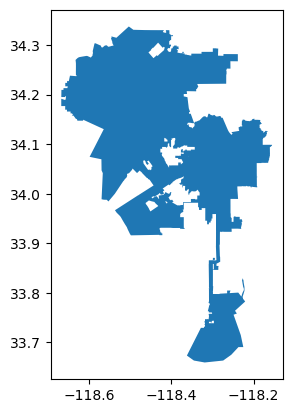

In [33]:
# Plot the area:
area.plot()

In [34]:
LA_map = folium.Map(location=[34.0522, -118.2437], tiles = 'cartodbpositron', zoom_start=10, control_scale=True)

In [35]:
LA_map

In [39]:
# Create a Map instance
m = folium.Map(location=[34.0522, -118.2437], tiles = 'cartodbpositron', zoom_start=10, control_scale=True)


folium.LayerControl().add_to(m)

#Show map
m

In [40]:
school = school.to_crs(epsg=4326)

In [42]:
# Create a Map instance
m = folium.Map(location=[34.0522, -118.2437], tiles = 'cartodbpositron', zoom_start=10, control_scale=True)

# Convert points to GeoJson
folium.GeoJson(school,  
                        name='schools',
                        style_function=lambda x: {'color':'transparent','fillColor':'transparent','weight':0},
                        tooltip=folium.features.GeoJsonTooltip(fields=['FULLNAME','nearest park'],
                                                                aliases = ['School Name', 'Nearest Park Name'],
                                                                labels=True,
                                                                sticky=False
                                                                            )
                       ).add_to(m)
folium.LayerControl().add_to(m)

m

In [43]:
outfp = "LA_Schools.html"
m.save(outfp)

In [49]:
# Create a Map instance
m = folium.Map(location=[34.0522, -118.2437], tiles='cartodbpositron', zoom_start=10, control_scale=True)

# Convert points to GeoJson
folium.GeoJson(school,  
               name='schools',
               style_function=lambda x: {'icon': 'graduation-cap', 'icon_size': [30, 30]},
               tooltip=folium.features.GeoJsonTooltip(fields=['FULLNAME','nearest park'],
                                                       aliases=['School Name', 'Nearest Park Name'],
                                                       labels=True,
                                                       sticky=False)
              ).add_to(m)
folium.LayerControl().add_to(m)

m